# IMPORTS

In [67]:
import sys
sys.path.append('../')

from copy import deepcopy

import sys
import os
import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import optuna
import torch
import pickle
import dill
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time

import ColorDataUtils.ConwayUtils as CU 
import ColorDataUtils.EyeTrackingUtils as ETutils
import NTdatasets.conway.cloud_datasets as datasets
import NTdatasets.conway.multi_datasets as multidata
from ColorDataUtils.multidata_utils import MultiExperiment, Experiment
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:1")
dtype = torch.float32

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
expt = 'J220715'
stimpos_fname = datadir+expt+'/'+expt+'_LP_stimpos.mat'
stimpos_matdat = sio.loadmat(stimpos_fname)

In [77]:
#stimpos_matdat['NX'] = 60
stimpos_matdat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'LLsNULL', 'LLsGLM', 'LLsGQM', 'drift_terms', 'Dreg', 'valLP', 'NX', 'RFcenters', 'top_corner', 'source'])

In [70]:
sio.savemat(datadir+expt+'/'+expt+'_LP_stimpos.mat', stimpos_matdat)

In [26]:
DATA_FNAME = '_CC_CC_v08'              # 'Jocamo_220715_full_CC_ETCC_nofix_v08'
STIMPOS_FNAME = '_stimpos.mat'         # 'J0715ProcGLMinfo.mat', 'LLsGLM.mat'
SHIFT_FNAME = '_CC_CC_shifts_best.mat' # 'BDshifts1.mat'
DF_FNAME = '_CC_CC_DFupdate.mat'       # 'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat'
# 'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat'

stimpos_fname = datadir+'J220715/J220715_UT'+STIMPOS_FNAME
stimpos_matdat = sio.loadmat(stimpos_fname)

shift_fname = datadir+'J220715/J220715'+SHIFT_FNAME
shift_matdat = sio.loadmat(shift_fname)

df_fname = datadir+'J220715/J220715'+DF_FNAME
df_matdat = sio.loadmat(df_fname)

In [27]:
import pprint
print('stimpos')
pprint.pprint(stimpos_matdat.keys())
print()

print('shifts')
pprint.pprint(shift_matdat.keys())
print()

print('df')
pprint.pprint(df_matdat.keys())
print()

stimpos
dict_keys(['__header__', '__version__', '__globals__', 'LLsNULL', 'LLsGLM', 'drift_terms', 'Dreg', 'RFcenters', 'top_corner', 'valUT', 'NX'])

shifts
dict_keys(['__header__', '__version__', '__globals__', 'fix_n', 'shifts', 'metricsLL', 'metricsTH', 'ETshifts', 'ETmetrics', 'Ctrain', 'Cval'])

df
dict_keys(['__header__', '__version__', '__globals__', 'XDF'])


In [28]:
fn = 'Jocamo_220715_full_CC_ETCC_nofix_v08_packaged'
num_lags=16

t0 = time()
data = datasets.ColorClouds(
    datadir='Cdata', filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
104.90312671661377 sec elapsed
167520 (167520 valid) time points
29 laminar units, 210 ET units


In [29]:
df_matdat_old = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( df_matdat_old['XDF'][:NT, :], dtype=torch.float32 )

In [30]:
sacc_matdat_old = sio.loadmat( datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = sacc_matdat_old['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = sacc_matdat_old['sac_binsB'][0, :]
sac_tsL = sacc_matdat_old['sac_binsL'][0, :]
sac_tsR = sacc_matdat_old['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = sacc_matdat_old['et1kHzB']
et60B = sacc_matdat_old['et60HzB']
et60all = sacc_matdat_old['et60Hz_all']

  Redoing fix_n with saccade inputs: 6827 saccades
3795 fixations


In [31]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valUT = UTunits[a]
NCv = len(valUT)
print("%d out of %d units used"%(len(valUT), len(UTunits)))

174 out of 195 units used


In [32]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, lam_units], data.dfs[:, lam_units]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valLP = lam_units[a]

In [33]:
glm_matdat_old = sio.loadmat('Cdata/LLsGLM.mat')
Dreg = glm_matdat_old['Dreg']
top_corner = glm_matdat_old['top_corner'][:, 0]
glm_matdat_old.keys()

dict_keys(['__header__', '__version__', '__globals__', 'LLsNULL', 'LLsGLM', 'drift_terms', 'Dreg', 'RFcenters', 'top_corner'])

In [34]:
matdat = sio.loadmat('Cdata/J0715ProcGLMinfo.mat')
LLsNULL = matdat['LLsNULL'][:,0]
LLsGLM = matdat['LLsGLM'][:,0]
LLsGLM2 = matdat['LLsGLM2'][:,0]
drift_terms = matdat['drift_terms']
RFcenters = matdat['RFcenters']

In [35]:
shift_matdat_old = sio.loadmat( 'Cdata/BDshifts1.mat' )
fix_n = shift_matdat_old['fix_n']
shifts = shift_matdat_old['shifts'] # for each fixation, the shift in x and y
metricsLL = shift_matdat_old['metricsLL']
metricsTH = shift_matdat_old['metricsTH']
ETshifts = shift_matdat_old['ETshifts']
ETmetrics = shift_matdat_old['ETmetrics']
Ukeeps = shift_matdat_old['Ctrain']
XVkeeps = shift_matdat_old['Cval']

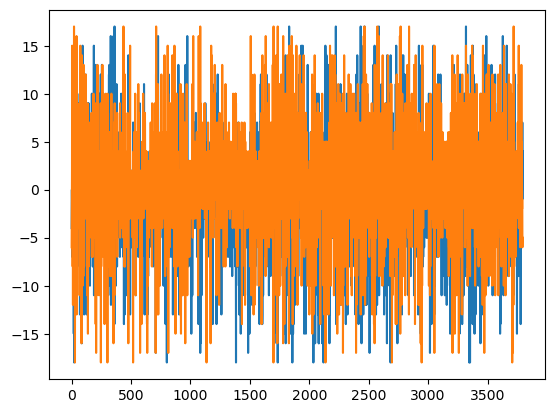

In [36]:
# compare shifts and ETshifts
plt.plot(shifts)

In [37]:
UTunits.shape

(195,)

In [39]:
stimpos_fname = datadir+'J220715/J220715_UT'+STIMPOS_FNAME+'.fb'
stimpos_matdat = sio.loadmat(stimpos_fname)
stimpos_matdat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'LLsNULL', 'LLsGLM', 'drift_terms', 'Dreg', 'RFcenters', 'top_corner', 'valUT'])

In [227]:
import pprint
print('stimpos')
stimpos_matdat_updated = {}
stimpos_matdat_updated['LLsNULL'] = LLsNULL
stimpos_matdat_updated['LLsGLM'] = LLsGLM
stimpos_matdat_updated['drift_terms'] = drift_terms
stimpos_matdat_updated['Dreg'] = glm_matdat_old['Dreg']
stimpos_matdat_updated['RFcenters'] = RFcenters
stimpos_matdat_updated['top_corner'] = glm_matdat_old['top_corner']
#stimpos_matdat_updated['UTunits'] = UTunits
#stimpos_matdat_updated['lam_units'] = lam_units
stimpos_matdat_updated['valUT'] = valUT
stimpos_matdat_updated['val_lam'] = val_lam
print()

print('shifts')
shift_matdat_updated = {}
shift_matdat_updated['fix_n'] = shift_matdat_old['fix_n']
shift_matdat_updated['shifts'] = shift_matdat_old['shifts']
shift_matdat_updated['metricsLL'] = shift_matdat_old['metricsLL']
shift_matdat_updated['metricsTH'] = shift_matdat_old['metricsTH']
shift_matdat_updated['ETshifts'] = shift_matdat_old['ETshifts']
shift_matdat_updated['ETmetrics'] = shift_matdat_old['ETmetrics']
shift_matdat_updated['Ctrain'] = shift_matdat_old['Ctrain']
shift_matdat_updated['Cval'] = shift_matdat_old['Cval']
print()

print('df')
df_matdat_updated = {}
df_matdat_updated['XDF'] = df_matdat_old['XDF']
print()

# save each of these as a mat file
sio.savemat('Cdata/J220715/J220715_UT'+STIMPOS_FNAME, stimpos_matdat_updated)
sio.savemat('Cdata/J220715/J220715'+SHIFT_FNAME, shift_matdat_updated)
sio.savemat('Cdata/J220715/J220715'+DF_FNAME, df_matdat_updated)

stimpos

shifts

df


# adjust RFcenter and add NX

In [60]:
expt = 'J220727'
#expt = 'J220718'

fn = expt+'/'+expt+'_CC_CC_v08'
num_lags=16

t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+expt+'/'+expt+'_CC_CC_DFupdate.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = 0.000 | 0.264
EYE CONFIG WARNING: non-contiguous blocks of correct eye position
Taking first contiguous block up to 53520
T-range: 0 53520
  Trimming experiment 149760->53520 time points based on eye_config and Tmax
42.43484544754028 sec elapsed
53520 (53520 valid) time points
44 laminar units, 175 ET units


In [61]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valUT = UTunits[a]
print(valUT)

[ 29  31  37  38  39  40  41  42  43  44  45  46  47  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 145 146 147 148 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218]


In [62]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, lam_units], data.dfs[:, lam_units]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valLP = lam_units[a]
print(valLP.shape)
print(valLP)

(41,)
[  0   1   2   3   4   5   6   9  10  11  12  13  24  25  26  27  28  30
  32  33  34  35  36 119 120 121 122 123 124 125 126 136 137 138 139 140
 141 142 143 144 149]


In [64]:
stimpos_matdat = sio.loadmat(datadir+expt+'/'+expt+'_LP_stimpos.mat.fb')
rf_centers = stimpos_matdat['RFcenters']
tc = stimpos_matdat['top_corner']

print(stimpos_matdat.keys())

print(np.mean(rf_centers[:,0]), np.mean(rf_centers[:,1]), tc)

for i in range(rf_centers.shape[0]):
    stimpos_matdat['RFcenters'][i, 0] = stimpos_matdat['RFcenters'][i, 0] + stimpos_matdat['top_corner'][0]
    stimpos_matdat['RFcenters'][i, 1] = stimpos_matdat['RFcenters'][i, 1] + stimpos_matdat['top_corner'][1]

rf_centers = stimpos_matdat['RFcenters']
tc = stimpos_matdat['top_corner']

print(np.mean(rf_centers[:,0]), np.mean(rf_centers[:,1]), tc)

stimpos_matdat['NX'] = 52
stimpos_matdat['valLP'] = valLP


print(stimpos_matdat['RFcenters'][:,[0]] - stimpos_matdat['top_corner'][[0]])
print(stimpos_matdat['RFcenters'][:,[1]] - stimpos_matdat['top_corner'][[1]])


sio.savemat('../Cdata/'+expt+'_LP_stimpos.mat', stimpos_matdat)

dict_keys(['__header__', '__version__', '__globals__', 'LLsNULL', 'LLsGLM', 'drift_terms', 'Dreg', 'RFcenters', 'top_corner'])
17.024390243902438 16.317073170731707 [[995]
 [550]]
1012.0243902439024 566.3170731707318 [[995]
 [550]]
[[21]
 [21]
 [18]
 [19]
 [16]
 [18]
 [15]
 [17]
 [18]
 [19]
 [19]
 [17]
 [15]
 [20]
 [17]
 [18]
 [17]
 [11]
 [15]
 [18]
 [13]
 [17]
 [14]
 [16]
 [17]
 [17]
 [16]
 [17]
 [17]
 [15]
 [17]
 [14]
 [17]
 [17]
 [15]
 [19]
 [27]
 [20]
 [12]
 [19]
 [13]]
[[14]
 [18]
 [17]
 [15]
 [15]
 [18]
 [18]
 [17]
 [17]
 [18]
 [18]
 [15]
 [18]
 [15]
 [16]
 [12]
 [10]
 [16]
 [15]
 [18]
 [14]
 [13]
 [16]
 [17]
 [15]
 [16]
 [18]
 [13]
 [18]
 [16]
 [15]
 [18]
 [15]
 [18]
 [14]
 [21]
 [25]
 [13]
 [17]
 [18]
 [19]]


In [324]:
stimpos_matdat = sio.loadmat('Cdata/J220715/J220715_UT'+STIMPOS_FNAME)
rf_centers = stimpos_matdat['RFcenters']
tc = stimpos_matdat['top_corner']
rf_centers, tc, stimpos_matdat['NX'], np.array(stimpos_matdat['NX'], dtype=np.int64).squeeze()

(array([[954, 541],
        [956, 541],
        [958, 541],
        [954, 543],
        [952, 539],
        [952, 540],
        [948, 539],
        [955, 542],
        [953, 540],
        [953, 539],
        [952, 538],
        [952, 542],
        [954, 543],
        [952, 542],
        [952, 543],
        [950, 542],
        [950, 541],
        [949, 539],
        [953, 542],
        [953, 543],
        [955, 545],
        [954, 544],
        [960, 544],
        [961, 544],
        [952, 540],
        [952, 545],
        [953, 540],
        [953, 543],
        [953, 542],
        [953, 543],
        [946, 543],
        [958, 543],
        [957, 545],
        [959, 544],
        [954, 545],
        [955, 543],
        [953, 542],
        [954, 542],
        [954, 545],
        [956, 544],
        [953, 543],
        [954, 542],
        [959, 545],
        [954, 543],
        [951, 541],
        [959, 545],
        [955, 542],
        [949, 538],
        [945, 542],
        [948, 544],


True

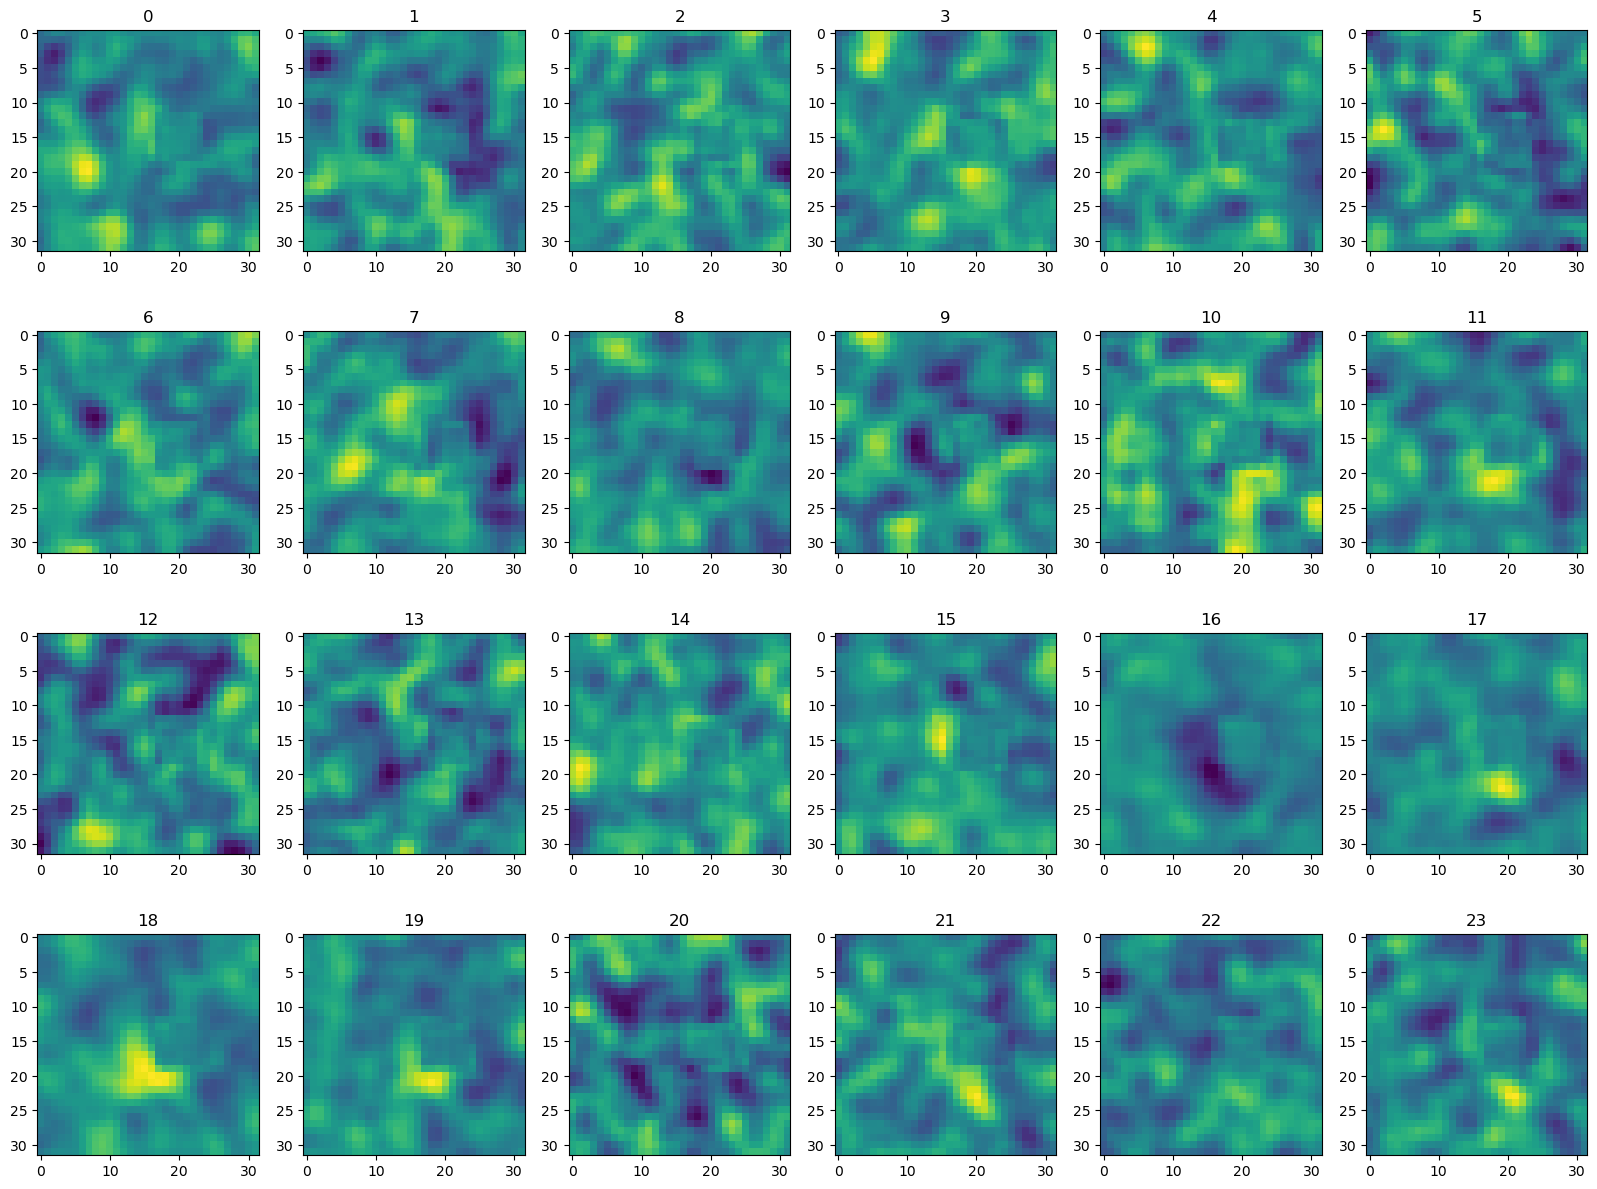

In [17]:
# with negation
expts.check_STAs(device=device, lag=6)


# load data

In [65]:
# load data
num_lags=16
L = 60
#expt_names = ['J220715','J220722','J220801','J220808']
expt_names = ['J220727', 'J220718']
expts = MultiExperiment(expt_names)
new_data, new_drift_terms, new_mu0s = expts.load(datadir, # '/home/dbutts/ColorV1/Data/'
           num_lags=num_lags,
           et_metric_thresh=0.8,
           array_types=['LP', 'LP'],
           luminance_only=True)

  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
153120 total time steps, 444 units
J220727 37.7% fixations remaining
J220718 48.2% fixations remaining
  Stim expansion for shift: [975, 530, 1067, 622]
  Writing lam stim 0: overlap 10, 8
  Writing lam stim 1: overlap 10, 60
  Writing lam stim 2: overlap 60, 60
  Writing lam stim 3: overlap 60, 8
  Shifting stim...


100%|███████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.14it/s]


  CROP: New stim size: 52 x 52
  Done: expt 0
  Stim expansion for shift: [920, 500, 1012, 592]
  Writing lam stim 0: overlap 44, 35
  Writing lam stim 1: overlap 44, 57
  Writing lam stim 2: overlap 48, 57
  Writing lam stim 3: overlap 48, 35
  Adding fixation point
  Shifting stim...


100%|███████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


  CROP: New stim size: 52 x 52
  Done: expt 1
Stimulus assembly complete


In [66]:
fn = 'J220715/J220715_CC_CC_v08'
num_lags=16

t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valET = UTunits[a]
NCv = len(valET)
print("%d out of %d units used"%(len(valET), len(UTunits)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
dirname2 = dirname+'0715/et/'
matdat = sio.loadmat(dirname2+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_corner = matdat['top_corner'][:, 0]

data.set_cells(valET)


# Load shifts and previous models
dirname2 = dirname+'0715/et/'
SHfile = sio.loadmat( dirname2 + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']

# Make 60x60 STAs (and GLMs)
Xshift = 14 #8+4 
Yshift = -3 #-10+4
NX = 60

new_tc = np.array([top_corner[0]-Xshift, top_corner[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts, num_lags=num_lags)
#data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, shifts=ETshifts, num_lags=num_lags)


goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix
("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))
dirname2 = dirname+'0715/NewGLMs/'
matdat = sio.loadmat(dirname2+'J0715ProcGLMinfo.mat')


dirname2 = dirname+'0715/NewGLMs/'
matdat = sio.loadmat(dirname2+'J0715ProcGLMinfo.mat')
LLsNULL = matdat['LLsNULL'][:,0]
LLsGLM = matdat['LLsGLM'][:,0]
LLsGLM2 = matdat['LLsGLM2'][:,0]
drift_terms = matdat['drift_terms']
valET = matdat['cells']
RFcenters = matdat['RFcenters']
#'Gregs': Gopt[:,None], 'XTregs': Xopt
#'top_corner': new_tc[:, None]})
mu0s = utils.pixel2grid(deepcopy(RFcenters[:, [1, 0]]), L=NX)

Reducing stimulus channels (3) to first dimension
Loading data into memory...



KeyboardInterrupt



In [226]:
shifts.shape, ETshifts.shape

((3795, 2), (167520, 2))

# compare new vs. old

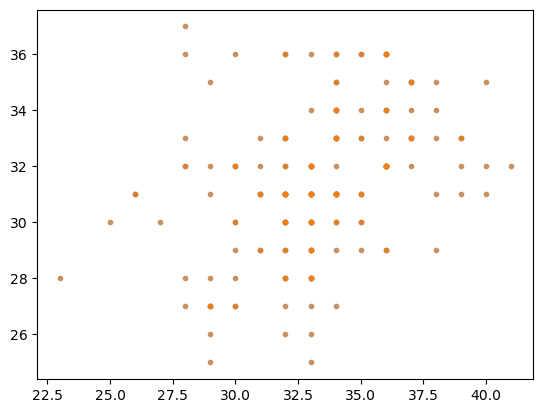

In [431]:
new_RF_center = expts[0].eRFcenter - expts[0].tc

plt.plot(RFcenters[:,0], RFcenters[:,1], '.', alpha=0.5)
#plt.plot(expts[0].eRFcenter[:,0]-expts[0].tc[0], expts[0].eRFcenter[:,1]-expts[0].tc[1], '.')
plt.plot(new_RF_center[:,0], new_RF_center[:,1], '.', alpha=0.5)

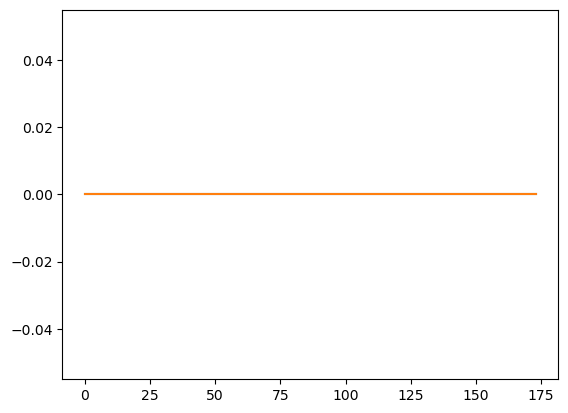

In [425]:
plt.plot(new_RF_center - RFcenters)

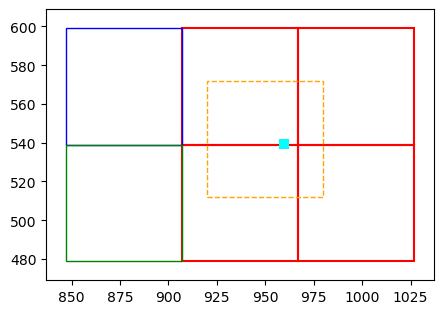

In [426]:
new_data.draw_stim_locations(top_corner = new_tc, L=NX)

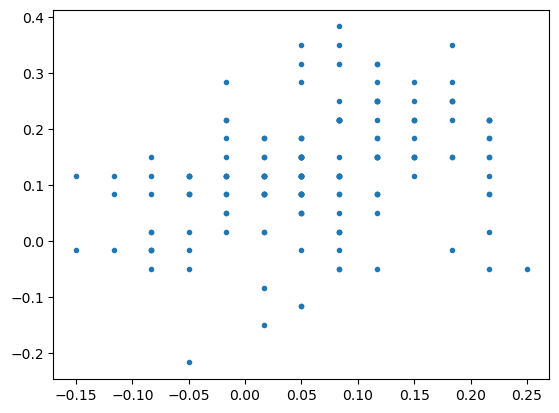

In [427]:
plt.plot(mu0s[:,0], mu0s[:,1], '.')

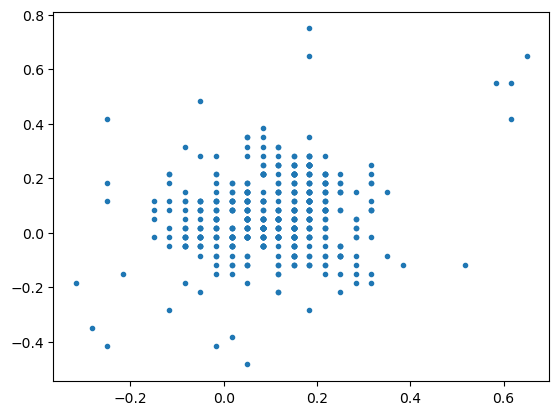

In [428]:
plt.plot(new_mu0s[:,0], new_mu0s[:,1], '.')

In [429]:
expts[0].NX

array(60)

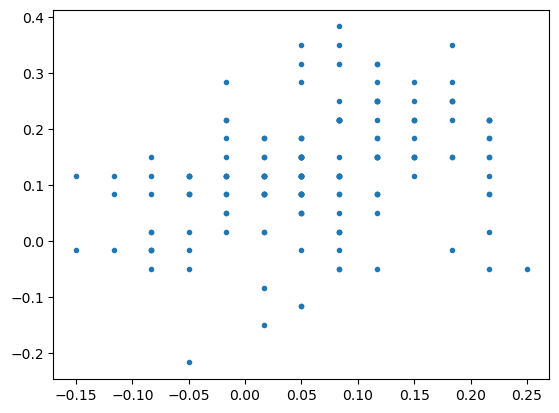

In [333]:
new_mu0s2 = np.zeros([new_data.NC, 2])
new_mu0s2[range(0, new_data.fileNC[0]), :] = utils.pixel2grid(deepcopy(expts[0].eRFcenter[:,[1,0]] - expts[0].tc[[1,0]]), L=NX)

mu0s2 = np.zeros([data.NC, 2])
mu0s2[range(0, 174), :] = utils.pixel2grid(deepcopy(RFcenters[:,[1,0]]), L=NX)
plt.plot(new_mu0s2[:,0], new_mu0s2[:,1], '.')

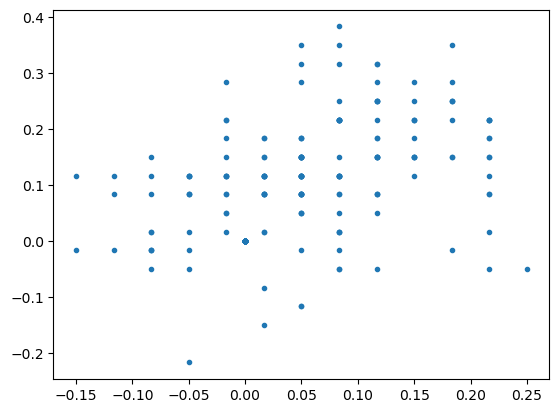

In [335]:
plt.plot(mu0s2[:,0], mu0s2[:,1], '.')

tc (905, 497)
width 100
center [954 541]


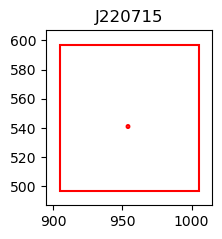

In [134]:
expts.plot_RFs()

0.0
[920 512]


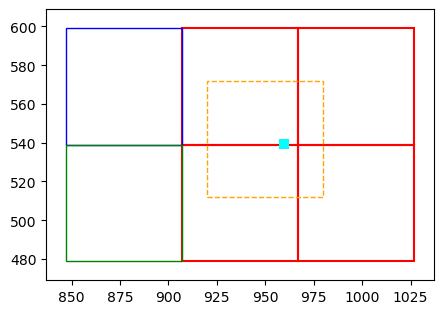

In [244]:
print(np.sum(data.stim))
print(expts[0].tc)
data.draw_stim_locations(top_corner=expts[0].tc, L=60)

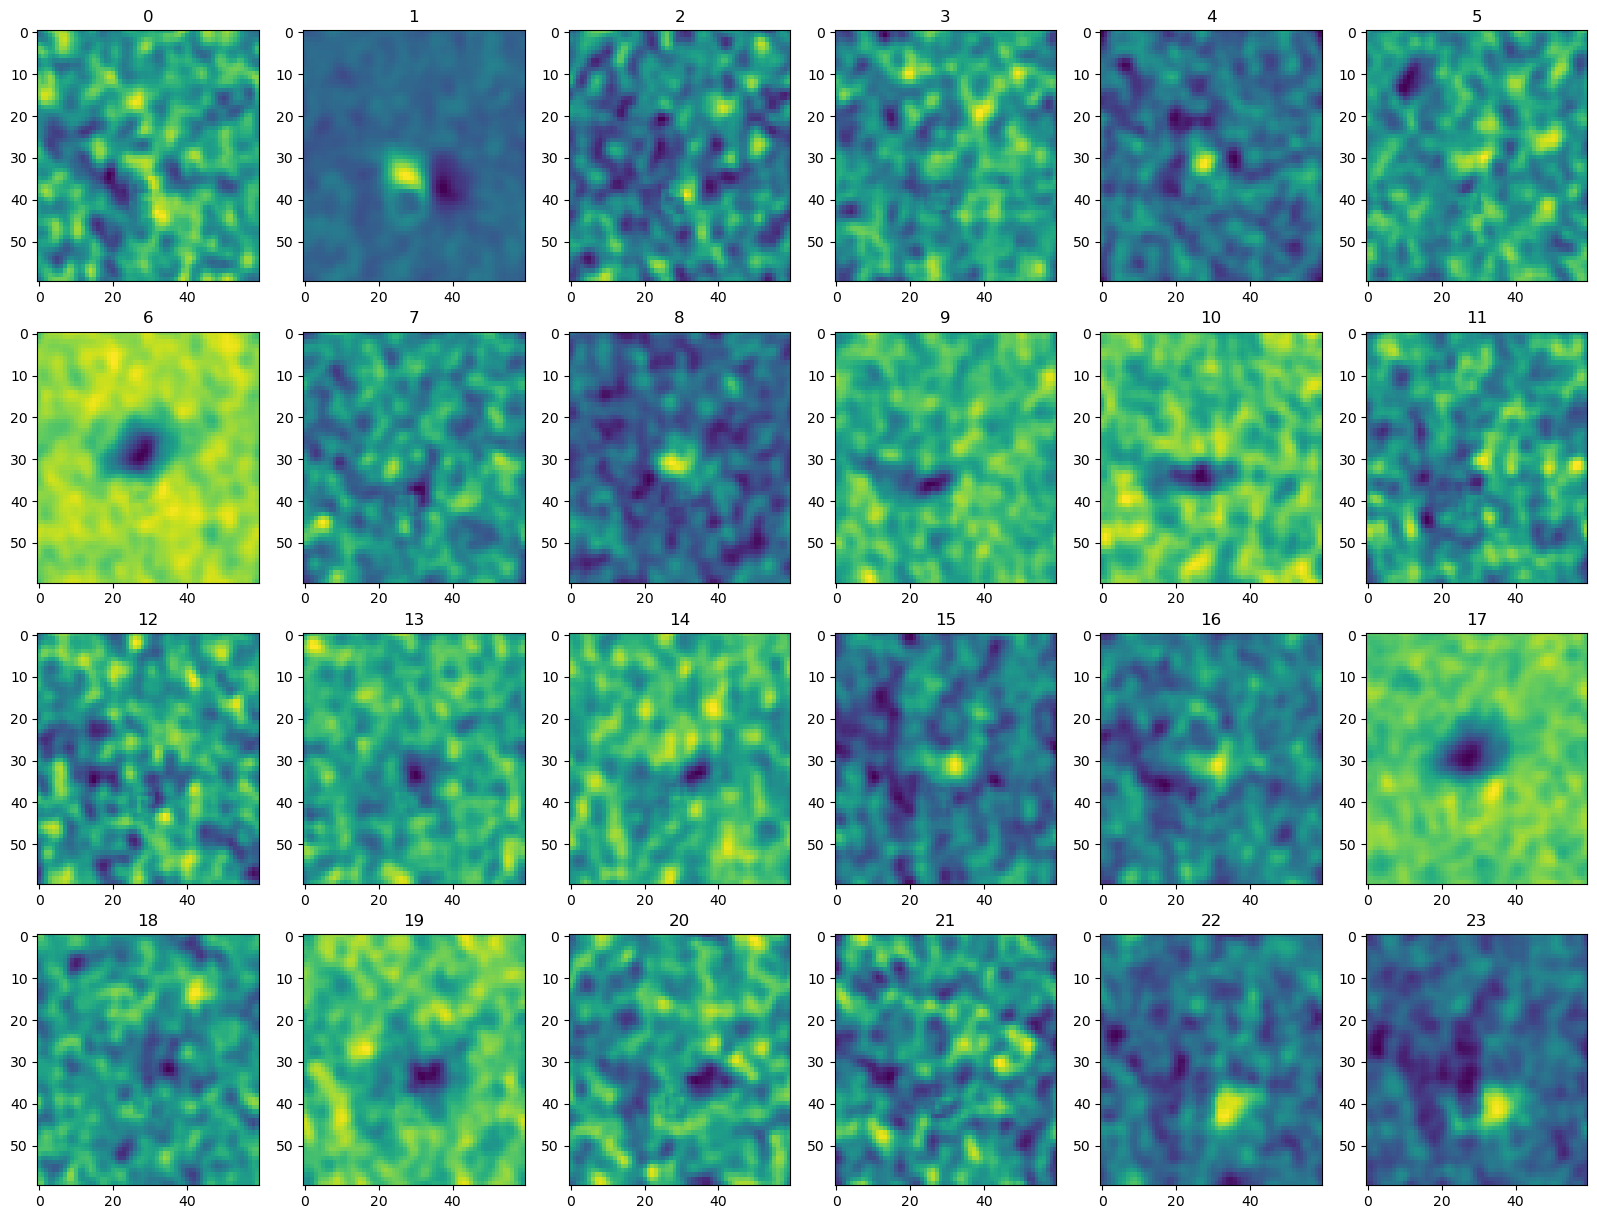

In [377]:
expts.check_STAs(device=device, lag=3)

In [373]:
expts[0].eRFcenter[:, [1,0]] - expts[0].tc[[1,0]]

array([[29, 34],
       [29, 36],
       [29, 38],
       [31, 34],
       [27, 32],
       [28, 32],
       [27, 28],
       [30, 35],
       [28, 33],
       [27, 33],
       [26, 32],
       [30, 32],
       [31, 34],
       [30, 32],
       [31, 32],
       [30, 30],
       [29, 30],
       [27, 29],
       [30, 33],
       [31, 33],
       [33, 35],
       [32, 34],
       [32, 40],
       [32, 41],
       [28, 32],
       [33, 32],
       [28, 33],
       [31, 33],
       [30, 33],
       [31, 33],
       [31, 26],
       [31, 38],
       [33, 37],
       [32, 39],
       [33, 34],
       [31, 35],
       [30, 33],
       [30, 34],
       [33, 34],
       [32, 36],
       [31, 33],
       [30, 34],
       [33, 39],
       [31, 34],
       [29, 31],
       [33, 39],
       [30, 35],
       [26, 29],
       [30, 25],
       [32, 28],
       [34, 38],
       [30, 32],
       [34, 37],
       [36, 36],
       [34, 36],
       [32, 33],
       [32, 30],
       [32, 32],
       [29, 31

In [61]:
data.dfs[:,0].shape, np.multiply(*data.dfs.shape), 160000/400, 620000/800

((167520,), 29148480, 400.0, 775.0)

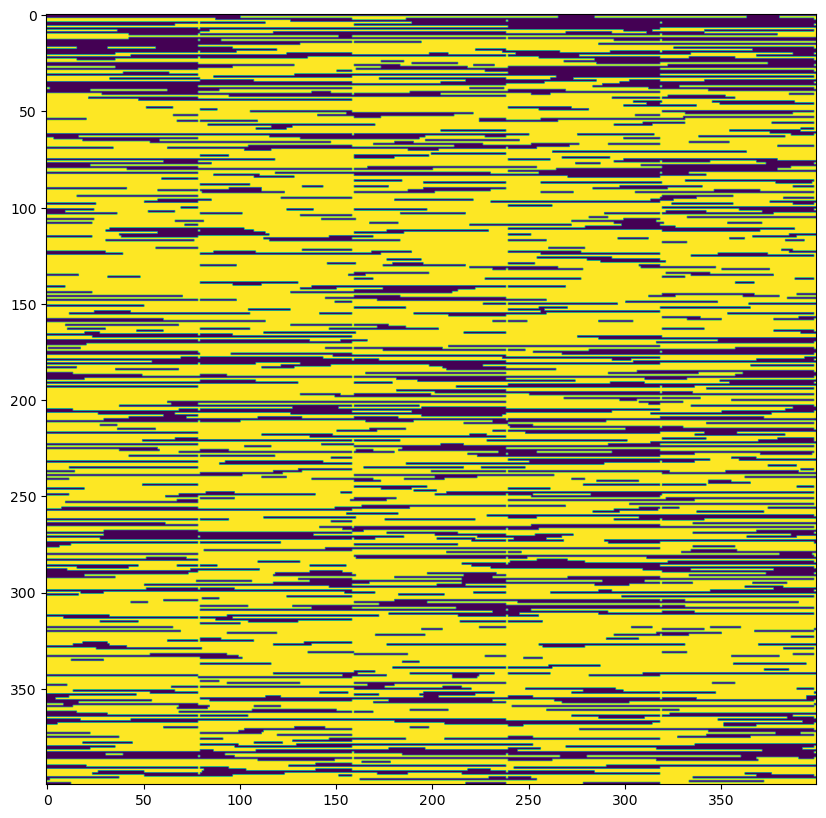

In [60]:
fig = plt.figure(figsize=(10,10))
plt.imshow(data.dfs[:160000,0].reshape(400,400))

#plt.imshow(data.dfs[:620000,500].reshape(800,775))
plt.show()

In [43]:
# setup
data.device = device
NCv = data.NC

# assemble drift terms
NA = 0
for expt in expts:
    NA += expt.edrift.shape[0]
drift_terms = np.zeros([NA, data.NC], dtype=np.float32)
acount, ccount = 0, 0
for ee, expt in enumerate(expts):
    NAtmp = expt.edrift.shape[0]
    slicer = np.zeros([NAtmp, data.NC])
    slicer[:, range(ccount, ccount+data.fileNC[ee])] = expt.edrift
    drift_terms[range(acount, acount+NAtmp), :] = deepcopy(slicer)
    ccount += data.fileNC[ee]
    acount += NAtmp

mu0s = np.zeros([data.NC, 2])
ccount = 0
for ee, expt in enumerate(expts):
    mu0s[range(ccount, ccount+data.fileNC[ee]), :] = utils.pixel2grid(deepcopy(expt.eRFcenter[:, [1, 0]]+[15,15]), L=L)
    ccount += data.fileNC[ee]

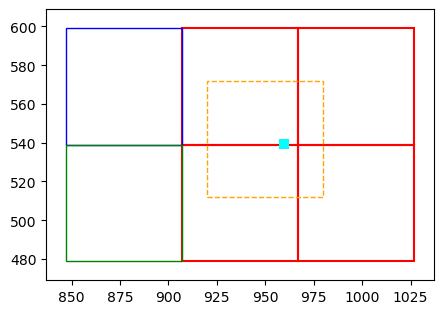

In [44]:
expt_names = ['J220715']
Xshift = 14 #8+4 
Yshift = -3 #-10+4
top_corner = expts[0].tc
new_tc = np.array([top_corner[0]-Xshift, top_corner[1]-Yshift], dtype=np.int64)

data.draw_stim_locations(top_corner = new_tc, L=60)

#data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=60, fixdot=0, shifts=expts[0].shift, num_lags=num_lags)

# STAs

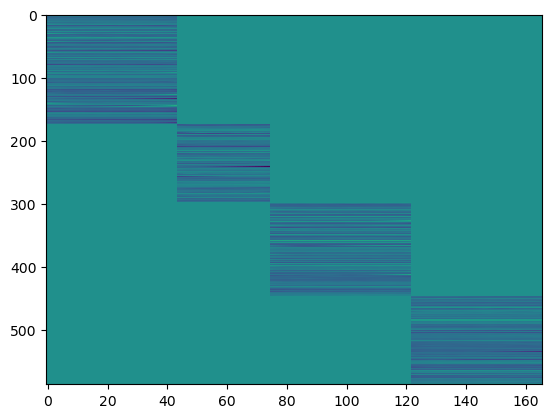

In [502]:
imagesc(new_drift_terms)

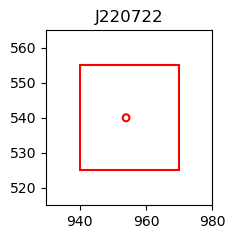

In [480]:
expts.plot_RFs(timebin=2)

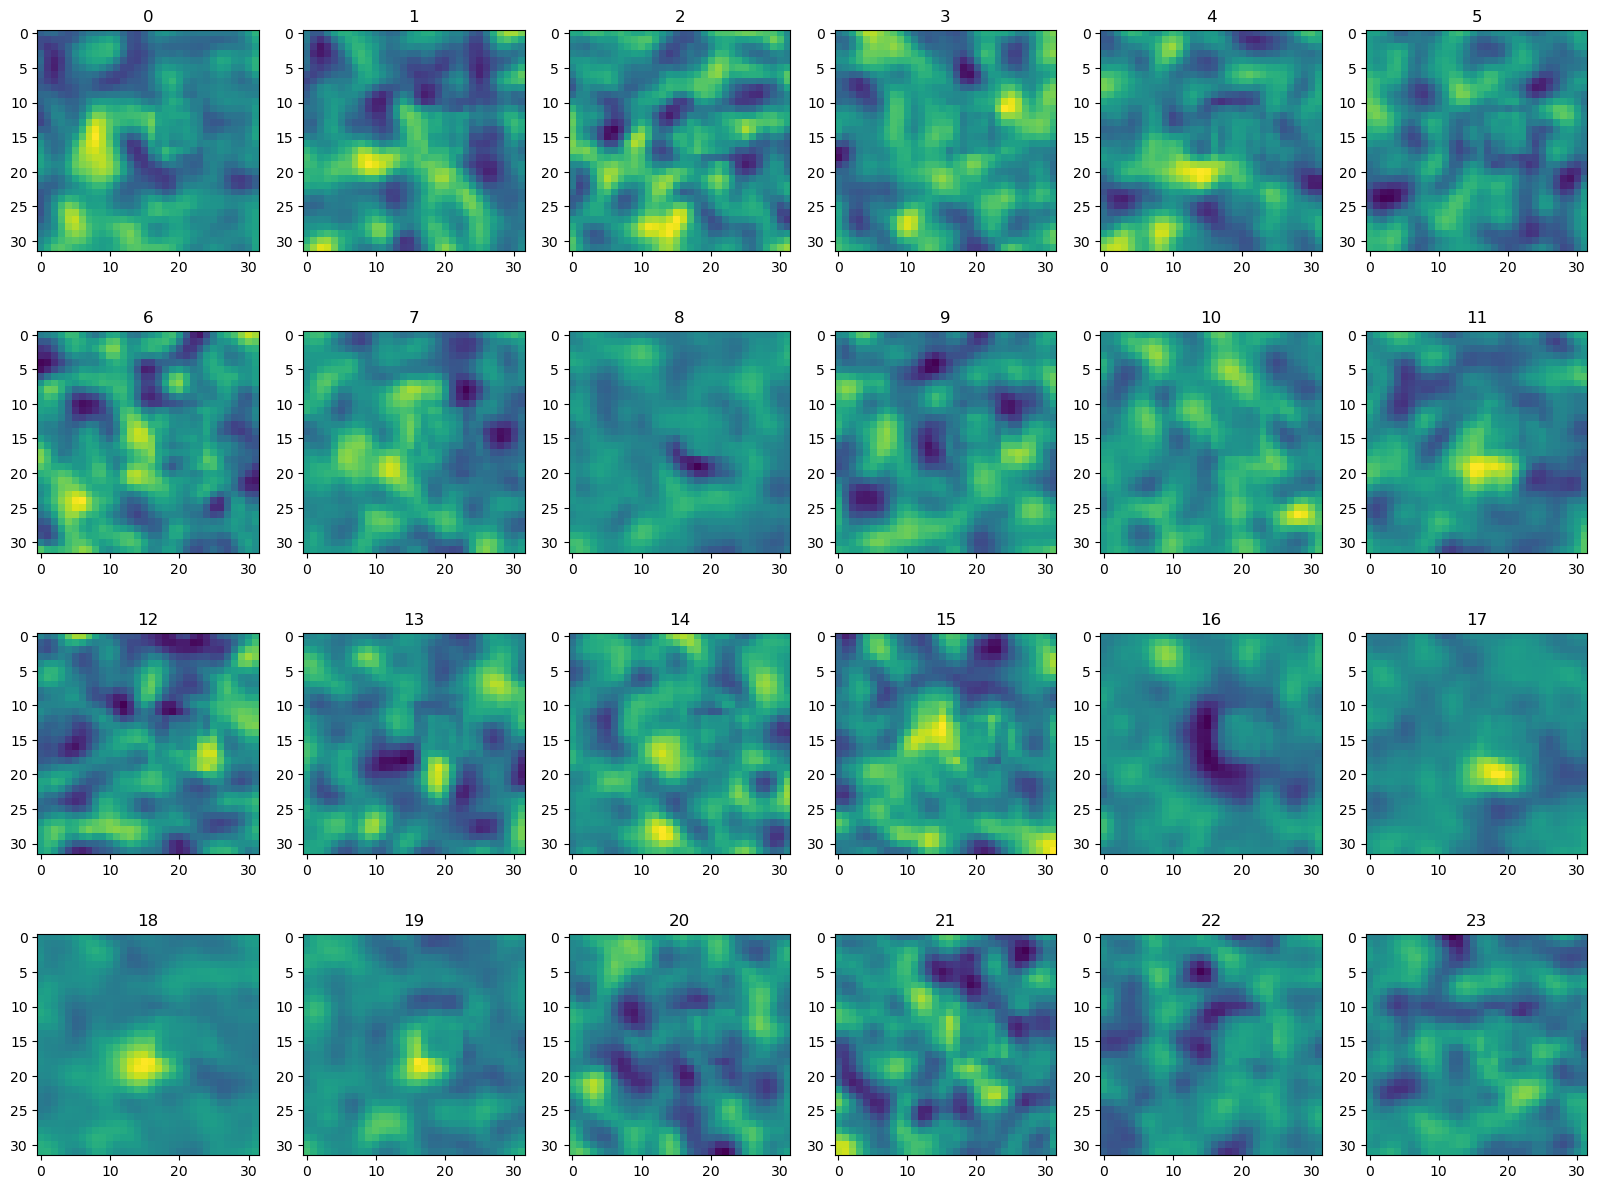

In [14]:
expts.check_STAs(device=device, lag=6)

In [508]:
stas = torch.zeros([L**2, new_data.NC])
nspks = torch.zeros(new_data.NC)
bsize = 40
lag = 6
for bb in range(len(new_data.block_inds)//bsize):
    ts =  np.arange(bb*bsize, (bb+1)*bsize)
    Reff = torch.mul(new_data[ts]['robs'], new_data[ts]['dfs'])
    nspks += torch.sum(Reff, axis=0)
    stas += (new_data[ts]['stim'][:-lag, ...].T @ Reff[lag:,:])

stas0 = (stas/nspks).reshape([L,L,new_data.NC]).detach().numpy()
stas0.shape

(60, 60, 587)

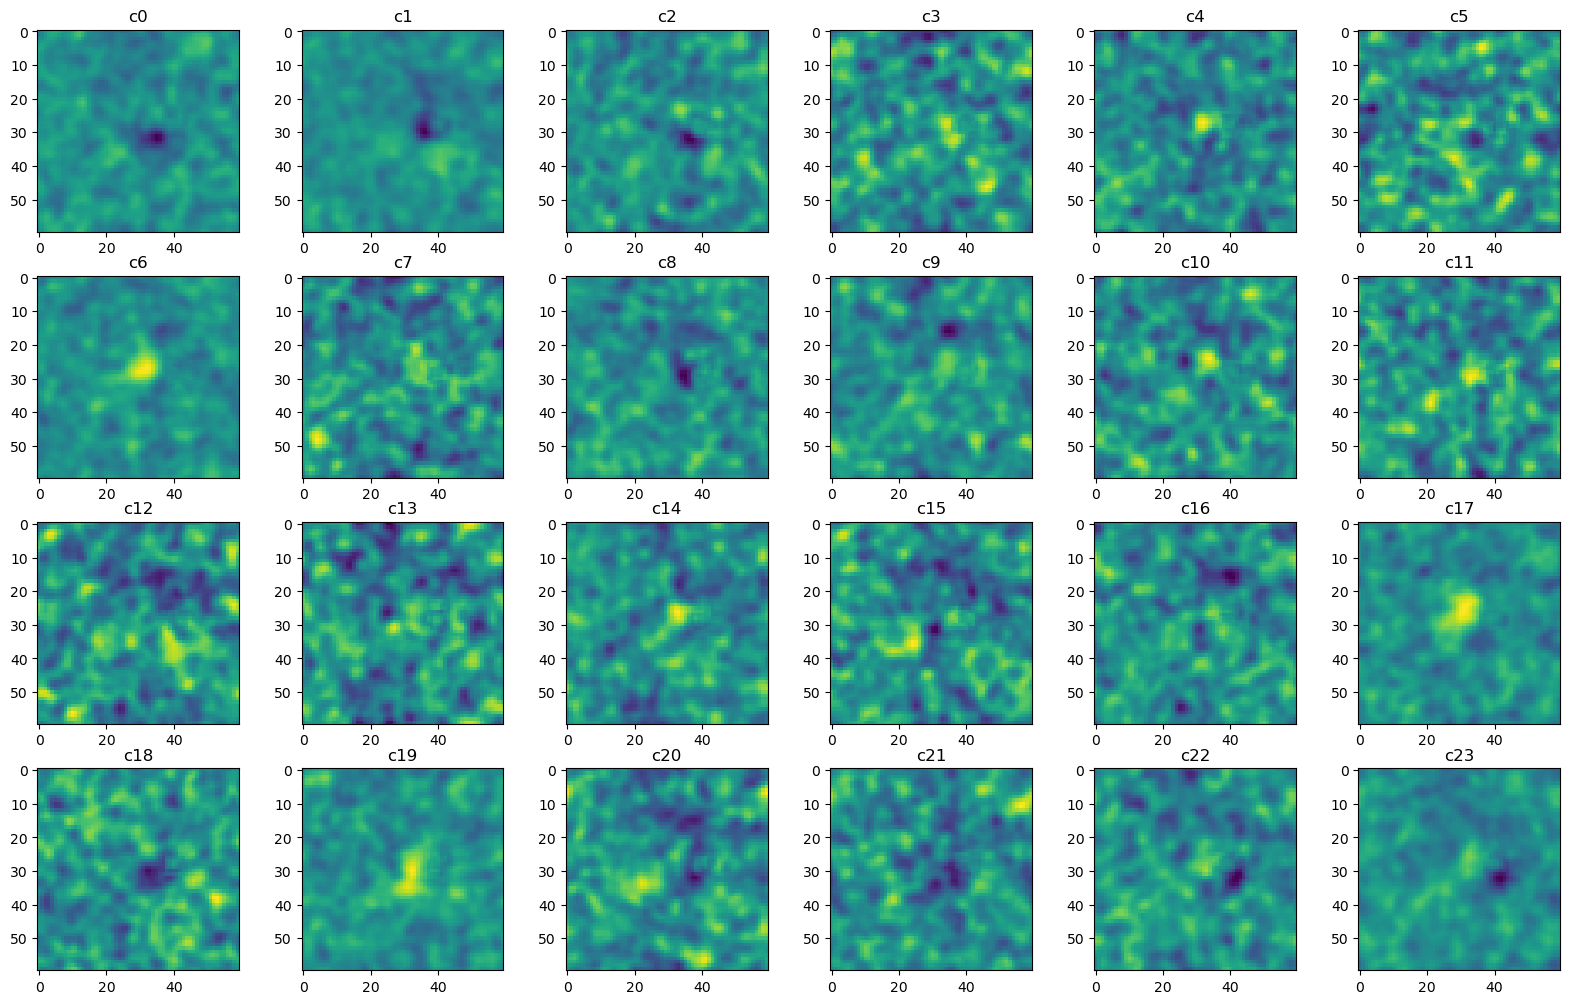

In [509]:
ss(4,6)
for cc in range(24):
    #for clr in range(3):
    plt.subplot(4,6, cc+1)
    imagesc(stas0[:,:,cc])
    plt.title('c%d'%cc)
plt.show()

/tmp/ipykernel_2061129/506823136.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stim = torch.tensor(data.stim, dtype=torch.float32, device=device)
/tmp/ipykernel_2061129/506823136.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  robs = torch.tensor(data.robs, dtype=torch.float32, device=device)
/tmp/ipykernel_2061129/506823136.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dfs = torch.tensor(data.dfs, dtype=torch.float32, device=device)


<class 'torch.Tensor'> <class 'torch.Tensor'>
(60, 60, 239)


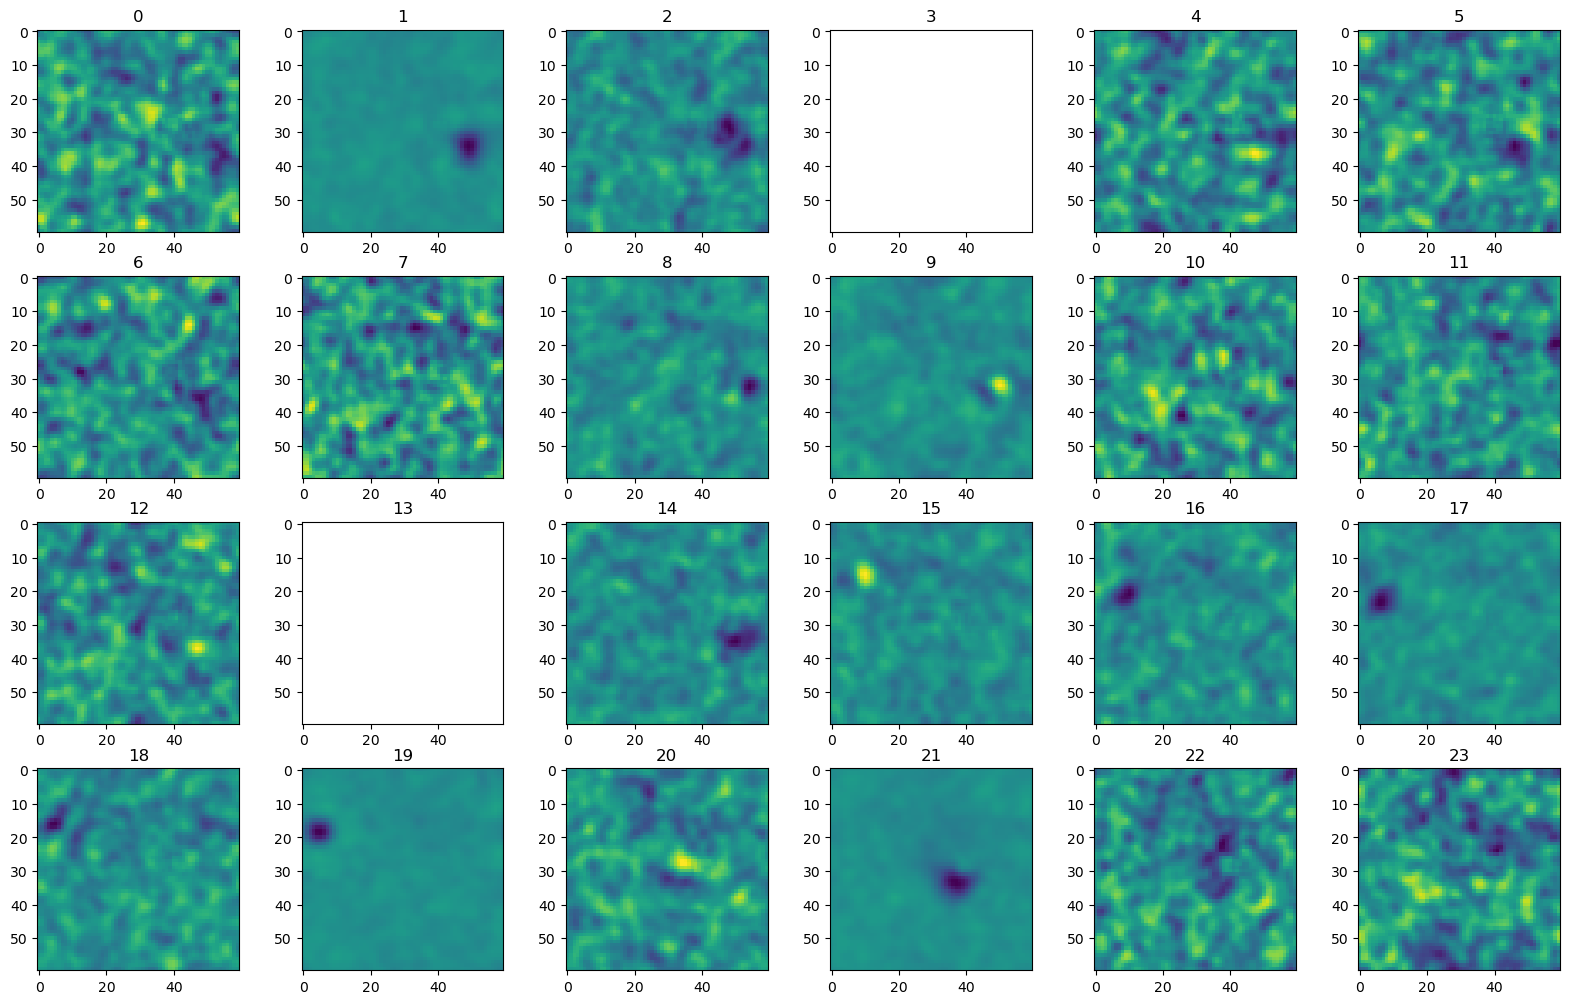

In [473]:
stim = torch.tensor(data.stim, dtype=torch.float32, device=device)
robs = torch.tensor(data.robs, dtype=torch.float32, device=device)
dfs = torch.tensor(data.dfs, dtype=torch.float32, device=device)
Reff = torch.mul(robs, dfs)
nspks = torch.sum(Reff, axis=0)
lag = 4

print(type(Reff), type(data.stim))
stas = ((stim[:-lag, ...].T @ Reff[lag:,:]).squeeze() / nspks).reshape([60,60,-1]).detach().cpu().numpy()
print(stas.shape)

# plot some STAs
ss(4,6)
for cc in range(24):
    plt.subplot(4,6, cc+1)
    imagesc(stas[:,:, cc])
    plt.title(str(cc))
plt.show()

In [388]:
stas = []
lag = 4
Reff = torch.mul(data.robs[:, valET], data.dfs[:, valET])
nspks = torch.sum(Reff, axis=0)
stas.append(((data.stim[-lag].T @ Reff[lag:,:]).squeeze() / nspks).reshape([60,60,-1]).detach().numpy())

IndexError: list index out of range

FileNotFoundError: [Errno 2] No such file or directory: '/home/dbutts/ColorV1/Data/<ColorDataUtils.multidata_utils.Experiment object at 0x7f7839f1f4d0>/<ColorDataUtils.multidata_utils.Experiment object at 0x7f7839f1f4d0>_UT_stimpos.mat'

# load old model

num models: 8


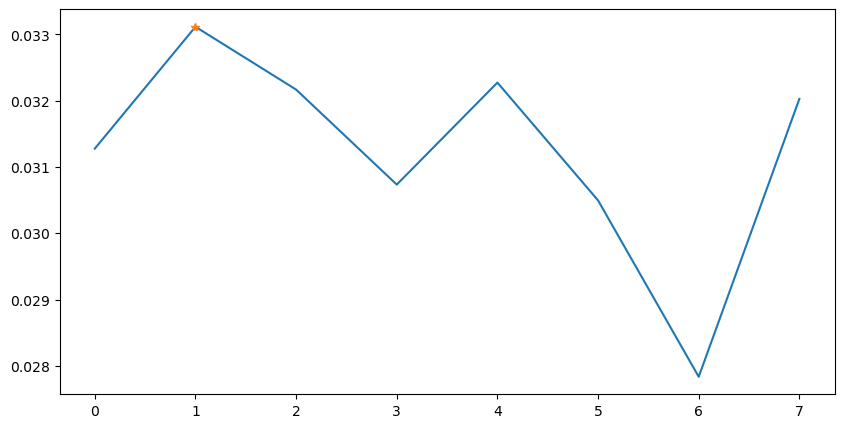

1


In [19]:
class Model:
    def __init__(self, ndn_model, LLs):
        self.ndn = ndn_model
        self.LLs = LLs

model_name = 'cnns_07'
num_models = 0
import glob
for file in glob.glob('models/'+model_name+'/cnn_*.pkl'):
    num_models += 1
print('num models:', num_models)

# make predictions from best CNN and best ITER
cnns = []
for i in range(0,num_models):
    with open('models/'+model_name+'/cnn_'+str(i)+'.pkl', 'rb') as f:
        cnns.append(pickle.load(f))

with open('models/'+model_name+'/study.pkl', 'rb') as f:
    study = pickle.load(f)

with open('models/'+model_name+'/pred.pkl', 'rb') as f:
    pred = pickle.load(f)

# plot LLs
fig = plt.figure(figsize=(10, 5))
plt.plot([np.mean(cnn.LLs) for cnn in cnns])
# put an asterisk on the best model
plt.plot(study.best_trial.number, np.mean(cnns[study.best_trial.number].LLs), '*')
plt.show()

best_cnn = cnns[study.best_trial.number].ndn_model
best_LLs = cnns[study.best_trial.number].LLs
best_trial = study.best_trial
print(study.best_trial.number)

In [24]:
best_cnn.networks[0].layers[2].LN_reverse = False
new_LLs = best_cnn.eval_models(new_data, data_inds=new_data.val_blks, batch_size=5)

Eval models: 100%|██████████████████████████████████████| 28/28 [03:01<00:00,  6.49s/it]


In [25]:
with open('models/cnns_multi_0715_05/cnn_0.pkl', 'rb') as f:
    new_cnn = pickle.load(f)

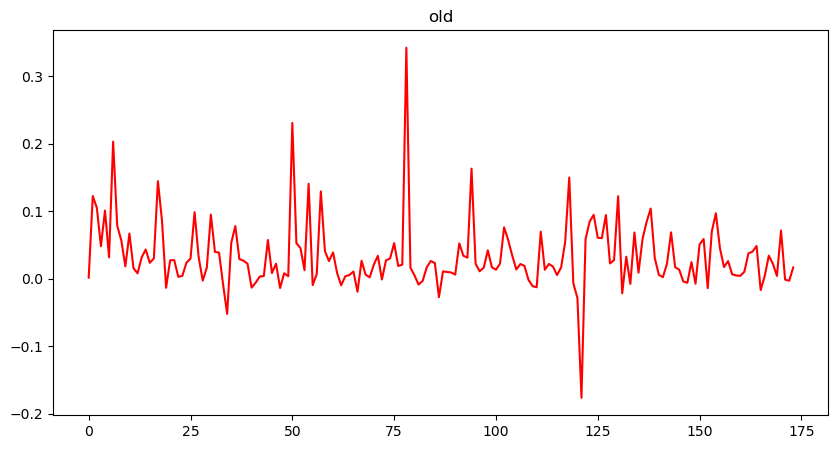

In [41]:
fig = plt.figure(figsize=(10, 5))
plt.plot(best_LLs, 'r')
plt.title('old')
plt.show()

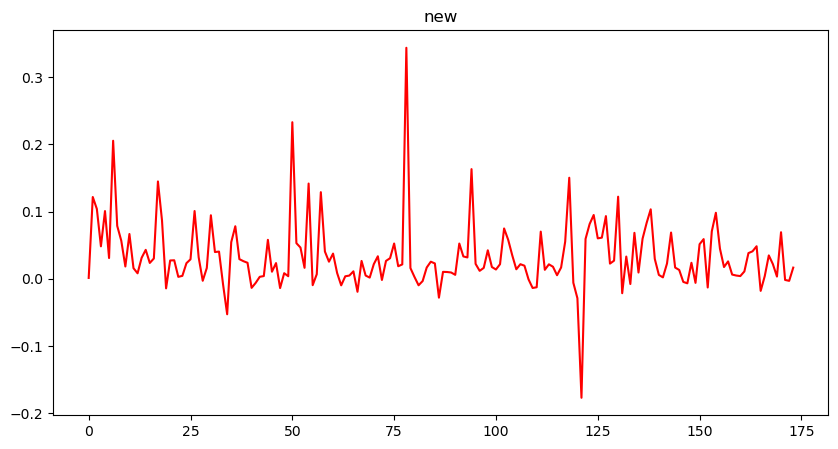

In [42]:
fig = plt.figure(figsize=(10, 5))
#plt.plot(new_cnn.LLs, 'b')
#plt.plot(expts[0].eLLsNULL - new_LLs, 'r')
plt.plot(expts[0].eLLsNULL - new_LLs, 'r')
plt.title('new')
plt.show()

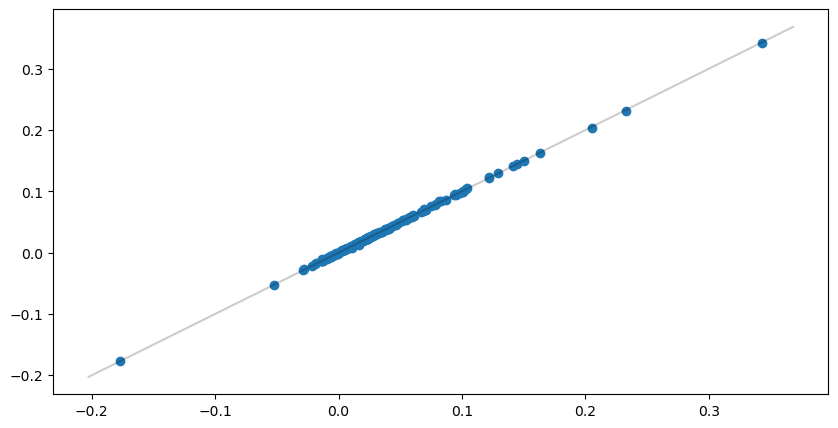

In [43]:
# plot a scatter
fig = plt.figure(figsize=(10, 5))
plt.scatter(expts[0].eLLsNULL - new_LLs, best_LLs)
# draw a line on the diagonal
ys = plt.ylim()
plt.plot(ys, ys, 'k', alpha=0.2)
plt.show()

In [44]:
np.mean(best_LLs), np.mean(expts[0].eLLsNULL - new_LLs)

(0.033114455212121724, 0.03310121)

In [47]:
np.mean(new_cnn.LLs)

0.025202872

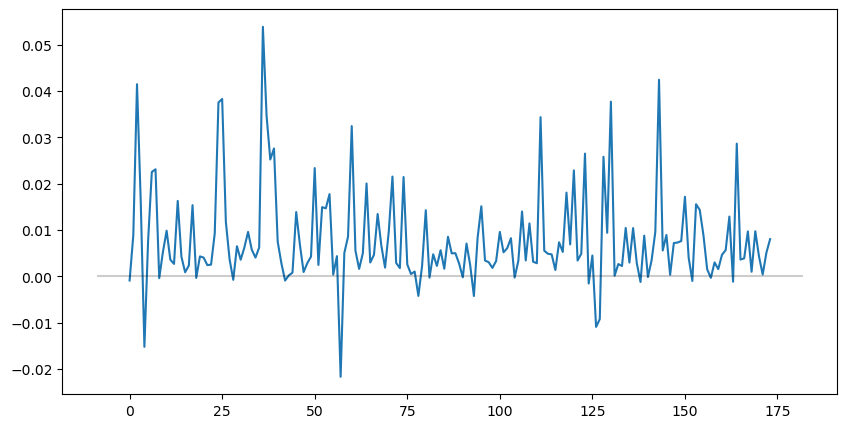

In [54]:
fig = plt.figure(figsize=(10, 5))
plt.plot(best_LLs - new_cnn.LLs)
# plot a horizontal line at 0
xs = plt.xlim()
plt.plot(xs, [0,0], 'k', alpha=0.2)
#plt.plot(best_LLs)
plt.show()

# load newest model

num models: 2


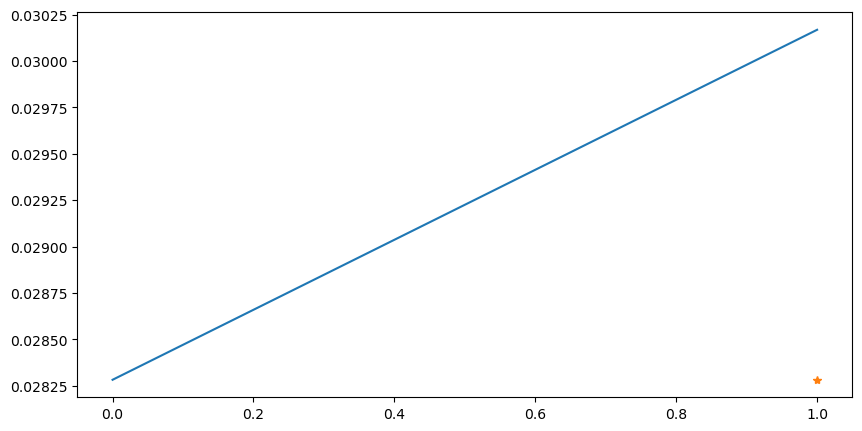

0
0.030168511


In [68]:
class Model:
    def __init__(self, ndn_model, LLs):
        self.ndn = ndn_model
        self.LLs = LLs

model_name = 'cnns_multi_06'
num_models = 0
import glob
for file in glob.glob('../models/'+model_name+'/cnn_*.pkl'):
    num_models += 1
print('num models:', num_models)

# make predictions from best CNN and best ITER
cnns = []
for i in range(0,num_models):
    with open('../models/'+model_name+'/cnn_'+str(i)+'.pkl', 'rb') as f:
        cnns.append(pickle.load(f))

with open('../models/'+model_name+'/study.pkl', 'rb') as f:
    study = pickle.load(f)

#with open('models/'+model_name+'/pred.pkl', 'rb') as f:
    #pred = pickle.load(f)

best_trial_number = 1 #study.best_trial.number

# plot LLs
fig = plt.figure(figsize=(10, 5))
plt.plot([np.mean(cnn.LLs) for cnn in cnns])
# put an asterisk on the best model
plt.plot(best_trial_number, np.mean(cnns[study.best_trial.number].LLs), '*')
plt.show()

best_cnn = cnns[best_trial_number].ndn_model
best_LLs = cnns[best_trial_number].LLs
best_trial = study.best_trial
print(study.best_trial.number)
print(np.mean(best_LLs))

In [69]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_iter_filter_width,params_num_inh,params_num_iter,params_num_subs,params_proj_NLtype,params_proj_filter_width,params_res_layer,system_attrs_fixed_params,state
0,0,0.028281,2023-08-16 18:52:05.155194,2023-08-17 01:37:01.965704,0 days 06:44:56.810510,15,0.69,7,45,relu,15,False,"{'iter_filter_width': 15, 'num_inh': 0.69, 'nu...",COMPLETE
1,1,NaN,2023-08-17 01:37:01.966071,NaT,NaT,15,0.69,7,45,relu,15,True,"{'iter_filter_width': 15, 'num_inh': 0.69, 'nu...",RUNNING


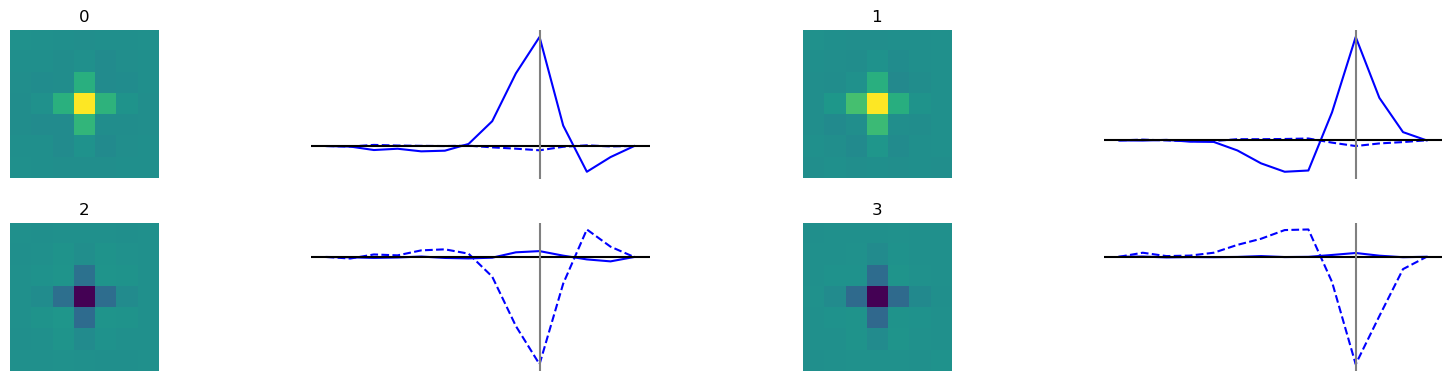

In [8]:
best_cnn.plot_filters()

In [6]:
with open('models/'+model_name+'/best_cnn.pkl', 'wb') as f:
    pickle.dump(best_cnn, f)

In [7]:
with open('models/'+model_name+'/best_cnn.pkl', 'rb') as f:
    best_cnn = pickle.load(f)